# Compare Transposon Counts

In [1]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA

In [2]:
phagesdf = read_phages(maxcontigs=-1)
phagesdf

Please note that this was run with git commit 86420e1 that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages,but after filtering we kept 3,265,453 prophages from 567,399 genomes

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...
567399,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
567400,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
567401,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
567402,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


In [3]:
tndf = read_transposons()
tndf

,assembly_accession,assembly_name,Genome Transposases,Prophage Transposases
0,GCA_000163335.1,ASM16333v1,35,0
1,GCA_000163355.2,ASM16335v2,5,0
2,GCA_000163375.2,ASM16337v2,4,0
3,GCA_000163395.2,ASM16339v2,6,0
4,GCA_000163415.1,ASM16341v1,1,0
...,...,...,...,...
567398,GCA_905219375.1,QI0054,4,0
567399,GCA_905219385.1,QI0055,4,0
567400,GCA_013456775.1,ASM1345677v1,71,3
567401,GCA_013459175.1,ASM1345917v1,63,1


In [4]:
ptn = pd.merge(phagesdf, tndf, on='assembly_accession', how='inner')
ptn

,assembly_accession,assembly_name_x,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,assembly_name_y,Genome Transposases,Prophage Transposases
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,ASM4328v1,0,0
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0,ASM4668v1,3,0
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0,ASM4670v1,1,0
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0,ASM4684v1,25,0
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0,ASM4736v1,63,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567394,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,5,1
567395,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0,ASM90518823v1,3,0
567396,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0,QI0054,4,0
567397,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0,QI0055,4,0


In [5]:
ptn['Non-phage Transposases'] = ptn['Genome Transposases'] - ptn['Prophage Transposases']
#ptn['gtkb'] = ptn['non phage transposons']/(ptn['Genome length']-ptn['bp prophage'])*1000
ptn['gtkb'] = ptn['Non-phage Transposases']/ptn['Genome length']*1000
ptn['ptkb'] = (ptn['Prophage Transposases']/ptn['bp prophage'])*2000
ptn['gtkbr'] = round(ptn['gtkb'], 2)
ptn['ptkbr'] = round(ptn['ptkb'], 2)
ptn['ratio'] = ptn['ptkb']/ptn['gtkb']
ptn['ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
ptn

,assembly_accession,assembly_name_x,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,assembly_name_y,Genome Transposases,Prophage Transposases,Non-phage Transposases,gtkb,ptkb,gtkbr,ptkbr,ratio
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,ASM4328v1,0,0,0,0.000000,NaN,0.00,NaN,NaN
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0,ASM4668v1,3,0,3,0.001897,0.000000,0.00,0.00,0.000000
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0,ASM4670v1,1,0,1,0.000518,0.000000,0.00,0.00,0.000000
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0,ASM4684v1,25,0,25,0.006947,0.000000,0.01,0.00,0.000000
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0,ASM4736v1,63,5,58,0.011981,0.046854,0.01,0.05,3.910647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567394,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,5,1,4,0.000816,0.009334,0.00,0.01,11.435915
567395,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0,ASM90518823v1,3,0,3,0.000604,0.000000,0.00,0.00,0.000000
567396,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0,QI0054,4,0,4,0.001318,0.000000,0.00,0.00,0.000000
567397,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0,QI0055,4,0,4,0.001318,0.000000,0.00,0.00,0.000000


In [6]:
ptn['ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
ptnb = ptn[(ptn['gtkb'] > 0) & (ptn['ptkb'] > 0)]
ptnb['ratio'].max()

3066.4453981878873

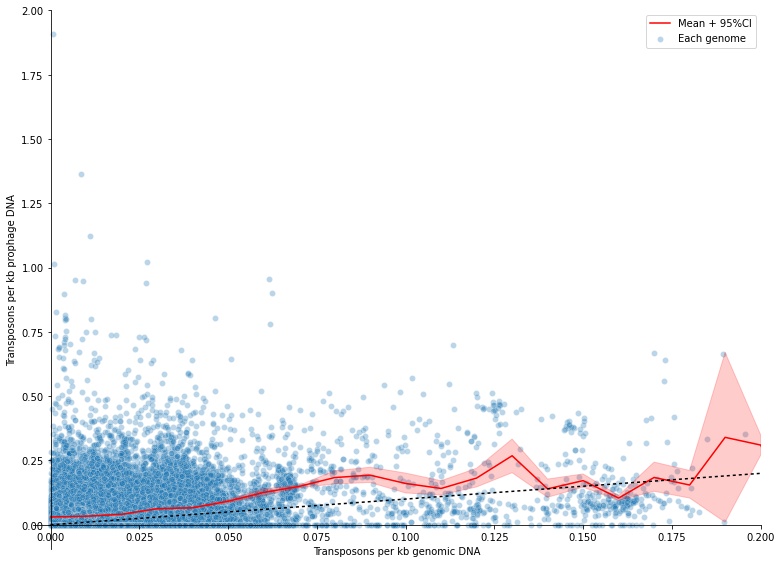

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sns.scatterplot(x='gtkb', y='ptkb', data=ptn, label="Each genome", alpha=0.3, ax=ax)
sns.lineplot(x='gtkbr', y='ptkbr', data=ptnb, label="Mean + 95%CI", color='r', ax=ax)
xlim = ax.get_xlim()
xlim = (-0.005, 0.2)
ylim = ax.get_ylim()
sns.lineplot(x=[0,1], y=[0,1], style=True, legend=False, color='k', dashes=[(2,2)], ax=ax)
l = ax.set_xlim(xlim)
l = ax.set_ylim(ylim)
l = ax.set_xlabel("Transposons per kb genomic DNA")
l = ax.set_ylabel("Transposons per kb prophage DNA")
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
#l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
#fig.savefig(f"images/transposons_per_kb.svg") ## too big!
fig.savefig(f"images/transposons_per_kb.png")

In [8]:
# read gtdb
gtdb = read_gtdb()

In [9]:
ptnc = pd.merge(ptn, gtdb[['assembly_accession', 'checkm_completeness']], on='assembly_accession', how='inner')
ptnc

,assembly_accession,assembly_name_x,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage,assembly_name_y,Genome Transposases,Prophage Transposases,Non-phage Transposases,gtkb,ptkb,gtkbr,ptkbr,ratio,checkm_completeness
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,ASM4328v1,0,0,0,0.000000,NaN,0.00,NaN,NaN,98.37
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0,ASM4668v1,3,0,3,0.001897,0.000000,0.00,0.00,0.000000,99.18
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0,ASM4670v1,1,0,1,0.000518,0.000000,0.00,0.00,0.000000,100.00
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0,ASM4684v1,25,0,25,0.006947,0.000000,0.01,0.00,0.000000,100.00
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0,ASM4736v1,63,5,58,0.011981,0.046854,0.01,0.05,3.910647,99.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126124,GCA_902158715.1,SB6413,6393461.0,62.0,43.0,31.0,1.0,10.0,20.0,24989.0,SB6413,1,0,1,0.000156,0.000000,0.00,0.00,0.000000,100.00
126125,GCA_902158725.1,SB6412,6006767.0,23.0,16.0,25.0,3.0,6.0,16.0,99240.0,SB6412,1,0,1,0.000166,0.000000,0.00,0.00,0.000000,100.00
126126,GCA_902167575.1,B.breve_2_mod_mod2,2406753.0,16.0,12.0,21.0,1.0,1.0,19.0,51094.0,B.breve_2_mod_mod2,17,0,17,0.007063,0.000000,0.01,0.00,0.000000,100.00
126127,GCA_902167585.1,Streptococcus_thermophilus_BgEED37_mod2,2310024.0,42.0,32.0,31.0,5.0,5.0,21.0,146320.0,Streptococcus_thermophilus_BgEED37_mod2,12,0,12,0.005195,0.000000,0.01,0.00,0.000000,99.88


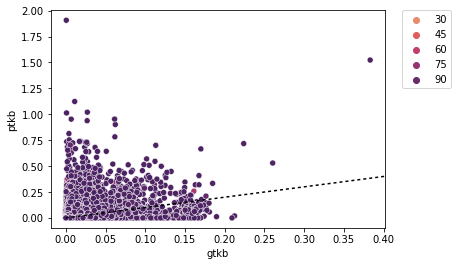

In [10]:
maxx = max(ptn['gtkb'])
maxy = max(ptn['ptkb'])
ax = sns.scatterplot(x='gtkb', y='ptkb', data=ptnc, hue='checkm_completeness', palette=sns.color_palette("flare", as_cmap=True))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
sns.lineplot(x=[0,1], y=[0,1], style=True, legend=False, color='k', dashes=[(2,2)], ax=ax)
l = ax.set_xlim(xlim)
l = ax.set_ylim(ylim)
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)